In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm, trange
# from sklearn import datasets
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"
import pickle
import blosc
from utils import *

In [2]:
with open("/Users/zsiga007/Summer_2022/Summer-2022/MegaAdaptiveSAM/MegaSAM/compressed_training", "rb") as f:
    compressed_pickle = f.read()

depressed_pickle = blosc.decompress(compressed_pickle)
training_set = pickle.loads(depressed_pickle)  # turn bytes object back into data

with open("/Users/zsiga007/Summer_2022/Summer-2022/MegaAdaptiveSAM/MegaSAM/compressed_test", "rb") as f:
    compressed_pickle = f.read()

depressed_pickle = blosc.decompress(compressed_pickle)
test_set = pickle.loads(depressed_pickle)

In [3]:
# train_loader2 = torch.utils.data.DataLoader(training_set, batch_size=1000, shuffle=True)
# C = np.random.rand(60,60)
# print(len(list(train_loader2)))
# shuffle = max_regrouping(C)
# print(len(shuffle))
# print(len(merge_loader(list(train_loader2), shuffle, batch_size=2000)))

In [3]:
output1 = 64
output2 = 32

MLP = nn.Sequential(
    nn.Linear(28 * 28, output1),
    nn.ReLU(),
    nn.Linear(output1, 10),
    # nn.ReLU(),
    # nn.Linear(output2, 10)
    )

In [4]:
model, training_losses, training_accuracies, validation_accuracies, optimizer = train_multi_model(
    model=MLP, train_data=training_set, test_data=test_set, optim='Adam', batch_size=1000, epochs=10, lr=0.01, tracking=True
)

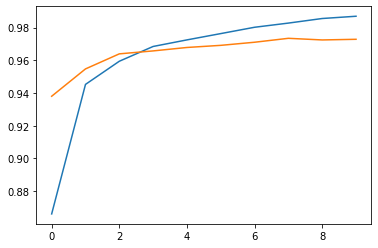

In [5]:
plt.plot(training_accuracies)
plt.plot(validation_accuracies)

In [6]:
validation_accuracies

[0.9380000233650208,
 0.9546999931335449,
 0.9639000296592712,
 0.9656999707221985,
 0.9678000211715698,
 0.9690999984741211,
 0.9710000157356262,
 0.9733999967575073,
 0.9724000096321106,
 0.9728000164031982]

In [7]:
training_accuracies

[0.866100013256073,
 0.9452333450317383,
 0.9593833088874817,
 0.968416690826416,
 0.97243332862854,
 0.9762833118438721,
 0.9801499843597412,
 0.982699990272522,
 0.9854999780654907,
 0.9868833422660828]

In [9]:
# print(list(train_loader)[0][0])

In [10]:
# output1 = 10

# model = nn.Sequential(
#     nn.Linear(2, output1),
#     nn.ReLU(),
#     nn.Linear(output1, 1)
# )

In [11]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
from tqdm.notebook import tqdm, trange
# torch.random.manual_seed(1572022)

output1 = 10
output2 = 10

model = nn.Sequential(
    nn.Linear(2, output1),
    nn.ReLU(),
    # nn.Linear(output1, output2),
    # nn.ReLU(),
    nn.Linear(output1, 1)
)

epochs = 100000
num_of_params = get_n_params(model)
C_tracking = True

lr = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer2 = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()

effective_ranks = []
losses = []
C_matrices = []

train_loader2 = torch.utils.data.DataLoader(train_data, batch_size=batch_size//2, shuffle=False) 

for epoch in trange(epochs):
    row_counter = 0
    tensor = torch.zeros((len(train_loader2),num_of_params))
    avg_loss = 0
    for points2, labels2 in train_loader2:
        optimizer2.zero_grad()
        x2 = points2[:,:,0].float()
        labels2 = labels2[:,None].double()

        y2 = model(x2)
        loss2 = criterion(y2, labels2)
        loss2.backward()
        # optimizer2.step()
        tensor[row_counter, :] = flatten_and_together([param.grad for param in list(model.parameters())])
        row_counter += 1
    C_matrix = tensor @ tensor.T
    C_matrix = C_matrix.detach().numpy()
    # print(C_matrix)
    new_shuffle = max_regrouping(C_matrix)
    # print(new_shuffle)
    # print('regr')
    new_loader_list = merge_loader(list(train_loader2), new_shuffle, batch_size=batch_size)
    # print(new_loader_list)
    # print(new_loader_list)
    train_loader = torch.utils.data.DataLoader(new_loader_list, batch_size=batch_size, shuffle=False)
    C_matrices.append(C_matrix)

    model.zero_grad()
    for points, labels in train_loader:
        optimizer.zero_grad()
        # print(points.shape)
        x = points[:,:,0].float()
        # x = points[:,:,0].reshape((batch_size,2)).float()
        # print(x.shape)
        labels = labels[:,None].double()
        # print(x)
        y = model(x)
        loss = criterion(y, labels)
        avg_loss += loss
        
        
        loss.backward()
        optimizer.step()
    losses.append(avg_loss/len(train_loader))


NameError: name 'train_data' is not defined

In [ ]:
C_matrices[0]

array([[-0.9741173 ,  0.12141047,  0.11356821,  0.09017908,  0.09290599,
         0.0845382 ,  0.07504169, -0.9741173 ,  0.12244484,  0.09504411,
        -0.9741173 ,  0.09980304,  0.074487  ,  0.11270556, -0.9741173 ,
         0.1108789 ],
       [ 0.12141047,  0.13571173,  0.1259258 ,  0.12683909,  0.1293122 ,
         0.10963774,  0.12015097,  0.15032712,  0.11361355,  0.09634767,
         0.14158157,  0.10696727,  0.09274919,  0.12315518,  0.10345288,
         0.1118922 ],
       [ 0.11356821,  0.1259258 ,  0.11717926,  0.11626725,  0.11881151,
         0.10079063,  0.1095765 , -0.9741173 ,  0.10638678,  0.08979107,
         0.13228749,  0.09922545,  0.08544549,  0.11458023,  0.09777093,
         0.10456234],
       [ 0.09017908,  0.12683909,  0.11626725,  0.15491009,  0.15319256,
         0.12549244,  0.16052042,  0.13041632,  0.07860065,  0.08115111,
         0.11827775,  0.09816344,  0.10118075,  0.10952366,  0.05179206,
         0.08899108],
       [ 0.09290599,  0.1293122 ,  0

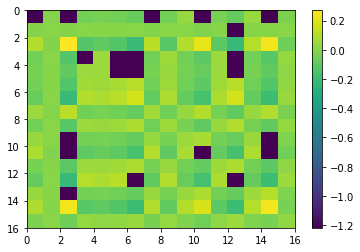

In [ ]:
plt.pcolor(C_matrices[-1])
plt.colorbar()
plt.gca().invert_yaxis()

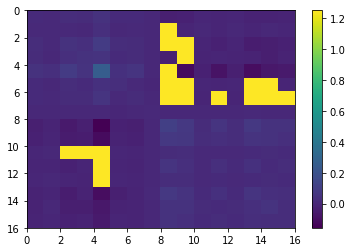

In [ ]:
C = C_matrices[-1]
A = (C>0.0)*1.0
from scipy.linalg import eigh
U, V = eigh(np.diag(A.sum(1)) - A)
v = V[:,1]
indices = np.argsort(v)
plt.pcolor(C[indices, :][:, indices])
plt.colorbar()
plt.gca().invert_yaxis()

In [ ]:
U[1]

3.1151482408231352

In [ ]:
diag_means = [c.diag().mean().numpy() for c in C_matrices]
plt.plot(diag_means)
N= C_matrices[0].shape[0]
non_diag_means = [(c.sum() - c.diag().sum().numpy()) / (N**2-N) for c in C_matrices]
plt.plot(non_diag_means)
average = [c.mean() for c in C_matrices]
plt.plot(average)

plt.ylim([-0.01,0.05])

AttributeError: 'numpy.ndarray' object has no attribute 'diag'

In [ ]:
# if C_tracking:
#     C_matrices[-1]
#     negatives = []
#     for C in C_matrices:
#         for col_ind, col in enumerate(C):
#             for row_ind, item in enumerate(col):
#                 if row_ind != col_ind and item < 0:
#                     negatives.append(item)
#     print("Negatives:", len(negatives))
#     print("Positives: ", 40**2-40-len(negatives))


Text(0, 0.5, 'Effective rank')

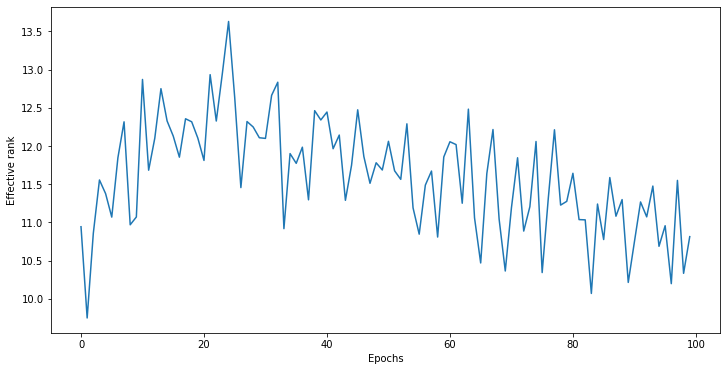

In [ ]:
from matplotlib.pyplot import figure

f = plt.figure()
f.set_figwidth(12)
f.set_figheight(6)

plt.plot(effective_ranks, '-')
plt.xlabel("Epochs")
plt.ylabel("Effective rank")

# arr = np.tanh(np.array(range(-epochs//2, epochs - epochs//2))/50) + 5.6 * np.ones(1000)
# plt.plot(arr)


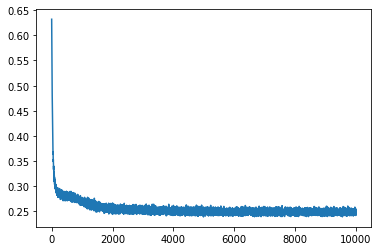

In [ ]:
plt.plot(losses)

In [ ]:
correct_test = 0
with torch.no_grad():
        # Iterate through test set minibatchs 
        for numbers2, labels2 in test_loader:
            numbers2 = numbers2
            labels2 = labels2.double()[:,None]
            # Forward pass
            x2 = numbers2[:,:,0].float()
            y2 = model(x2)
            predictions2 = ((y2>0)*1)
            # print(predictions2)
            # print(labels2)
            correct_test += torch.sum((predictions2 == labels2).float())
            # print(correct_test)
print(f'Test accuracy: {correct_test/len(test_data)}')


Test accuracy: 0.875


In [ ]:
# train_data = all_data[:N*8//10]
# test_data = all_data[N*8//10:]
# batch_size = 20
# items = np.zeros(150)

# def optimize():
#     train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
#     test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

#     epochs = 150
#     num_of_params = get_n_params(model)
#     C_tracking = False


#     optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
#     criterion = nn.BCEWithLogitsLoss()

#     effective_ranks = []

#     for epoch in trange(epochs):
#         row_counter = 0
#         tensor = torch.zeros((len(train_loader),num_of_params))
#         C_matrices = []
#         for points, labels in train_loader:
            
#             optimizer.zero_grad()

#             x = points[:,:,0].float()
#             # print(x.shape)
#             labels = labels[:,None].double()

#             y = model(x)
#             loss = criterion(y, labels)
            
#             loss.backward()
#             optimizer.step()

#             tensor[row_counter, :] = flatten_and_together([param.grad for param in list(model.parameters())])
#             row_counter += 1
#         if C_tracking:
#             C_matrix = tensor @ tensor.T
#             C_diags = np.sqrt(np.outer(tensor.diagonal(), tensor.diagonal()))
#             C_matrices.append(C_matrix)
#         effective_ranks.append(effective_rank(tensor))
#     return effective_ranks

# # for i in range(10):
# #     items += optimize()
# # meanarray = np.array(items) / 10

In [ ]:
# f = plt.figure()
# f.set_figwidth(12)
# f.set_figheight(6)

# plt.plot(meanarray, '.-')
# plt.xlabel("Epochs")
# plt.ylabel("Effective rank")

# # print(items)